# Configuration
____________________

In [ ]:
# set main directories
BASE_DIR = '/content/gdrive/MyDrive/AML_project/project/'
UTILS_DIR = BASE_DIR + 'utils'
DATA_DIR = BASE_DIR + 'data/'
TOKENIZER_DIR = BASE_DIR + 'tokenizers/'
# mount drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
# set utils directory
import sys
sys.path.append(UTILS_DIR)


Mounted at /content/gdrive


# Imports
____________________

In [ ]:
import io
import numpy as np
import pandas as pd
import nltk
import itertools
import string
import re
import sys
import json
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud
from google.colab import drive
from itertools import cycle
from collections import OrderedDict
# custom imports
from preprocessing import Preprocessor
from utils import getComments

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Load data
____________________

In [ ]:
# load original train
train = pd.read_csv(DATA_DIR + 'train.csv')

# Utils
____________________

In [ ]:
# change width of bars
def change_width(ax, new_value) :
  for patch in ax.patches :
    current_width = patch.get_width()
    diff = current_width - new_value

    # we change the bar width
    patch.set_width(new_value)

    # we recenter the bar
    patch.set_x(patch.get_x() + diff * .5)

# plot a hist
def plotHist(x, y, title, orient='v'):
  sns.set_style("white")
  figure(figsize=(10,6))
  ax = sns.barplot(x=x, y=y, orient=orient)
  plt.xlabel('Labels', fontsize=18)
  plt.ylabel('Number of instances', fontsize=18)
  plt.title(title, fontsize=16)
  change_width(ax, 0.3)
  plt.show(ax)

# get wordcloud for some most words
def getWordCloud(most_common_words):
  wc = WordCloud()
  wc.generate_from_frequencies(frequencies=dict(most_common_words))
  sns.reset_orig()
  figure(figsize=(10,10))
  plt.axis("off")
  plt.imshow(wc)

# plot top n words
def plotMostCommonWords(most_common_words, n_words, title):
  val, cnt = (zip(*most_common_words))
  val, cnt = list(val[0:n_words]), list(cnt[0:n_words])
  sns.set_style("white")
  figure(figsize=(20,8))
  plt.bar(np.arange(n_words), cnt, label=True)
  plt.xticks(np.arange(len(cnt)), val)
  plt.xlabel('Top words', fontsize=18)
  plt.ylabel('Word frequency', fontsize=18)
  plt.title(title, fontsize=18)
  plt.show()

labels = ['toxic', 'severe_toxic',	'obscene',	'threat',	'insult',	'identity_hate']

# Data exploration
____________________

### Let's see some of the data it contains

In [ ]:
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


### Let's see some of the content of those comments

In [ ]:
p = Preprocessor(replace_emojis=False)

# preprocess text to remove irrelevant words
preprocessed_train = train.copy()
preprocessed_train['comment_text'] = preprocessed_train['comment_text'].map(p.preprocessDoc)

# filter toxic comments
toxic_comments = getComments(preprocessed_train, clean=False)['comment_text'].values


# filter non-toxic comments
non_toxic_comments = getComments(preprocessed_train, clean=True)['comment_text'].values

# tokenize documents
toxic_comments_tokens = [p.tokenize(doc) for doc in toxic_comments]
non_toxic_comments_tokens = [p.tokenize(doc) for doc in non_toxic_comments]

# flatten lists to compute most common words
toxic_comments_tokens = list(itertools.chain.from_iterable(toxic_comments_tokens))
non_toxic_comments_tokens = list(itertools.chain.from_iterable(non_toxic_comments_tokens))

Let's visualize wordclouds for non toxic comments

In [ ]:
c = Counter(non_toxic_comments_tokens)
most_common_non_toxic = c.most_common()

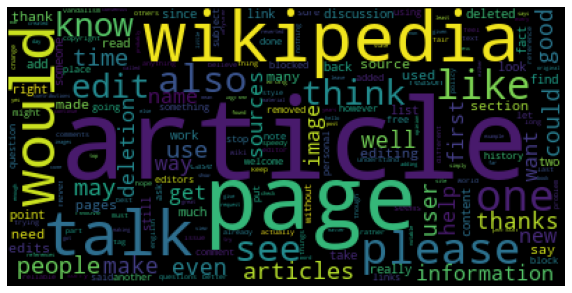

In [ ]:
getWordCloud(most_common_non_toxic)

Let's also plot the most common words for this category

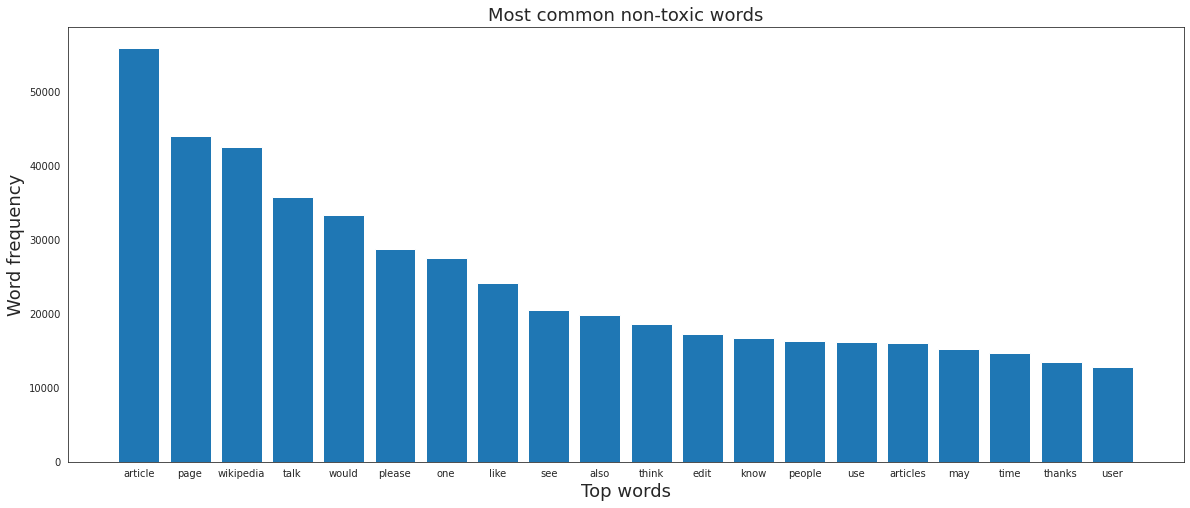

In [ ]:
plotMostCommonWords(most_common_non_toxic, 20, 'Most common non-toxic words')

Let's visualize wordclouds for toxic comments

In [ ]:
c = Counter(toxic_comments_tokens)
most_common_toxic = c.most_common()

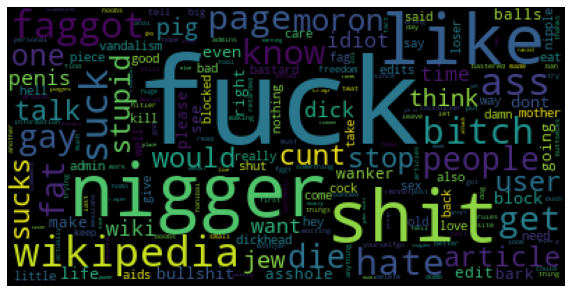

In [ ]:
getWordCloud(most_common_toxic)

Let's also plot the most common words for this category

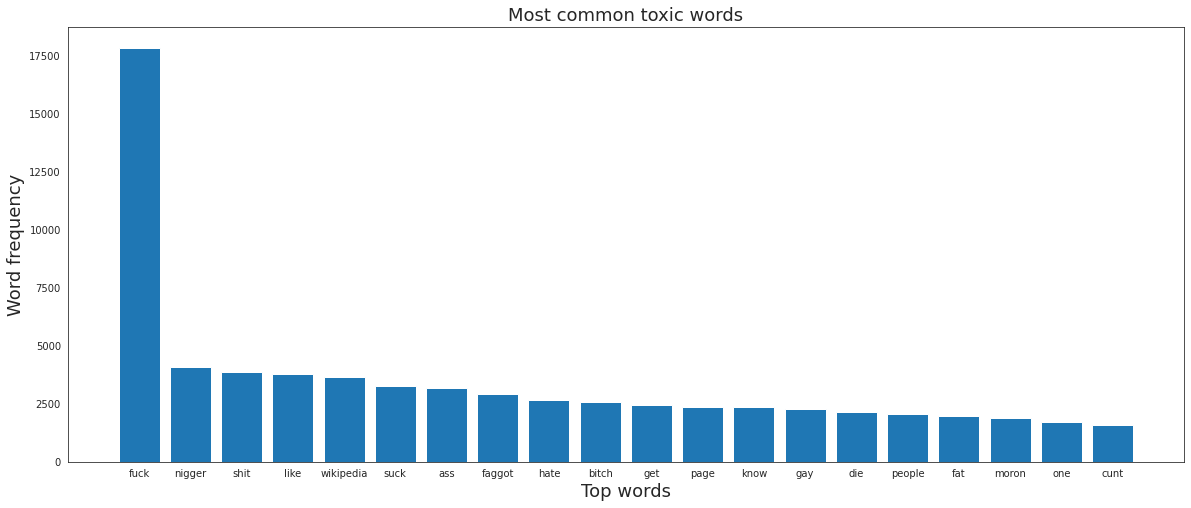

In [ ]:
plotMostCommonWords(most_common_toxic, 20, 'Most common toxic words')

### Let's see the ratio between toxic and non toxic comments

In [ ]:
print('Number of non toxic instances: ', len(non_toxic_comments))
print('Number of toxic instances: ', len(toxic_comments))

Number of non toxic instances:  143346
Number of toxic instances:  16225


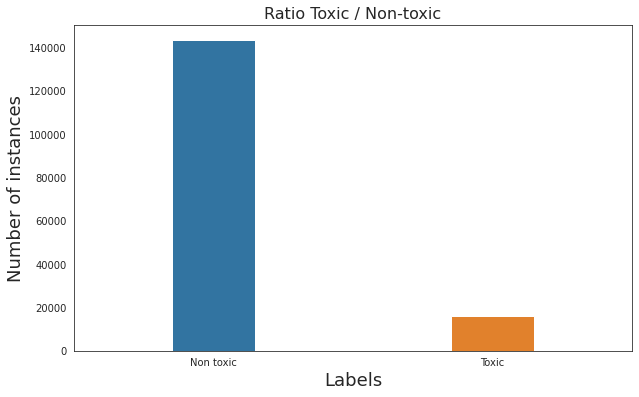

In [ ]:
plotHist(y=[len(non_toxic_comments), len(toxic_comments)], x=['Non toxic', 'Toxic'], title='Ratio Toxic / Non-toxic')

As we can see the dataset is really unbalanced towards the non toxic examples. In fact toxic comments are only about `10%` of the training data.

### Let's see the distribution of toxic labels

In [ ]:
# sum the columns for each label
sum_labels = train[labels].sum(axis=0)

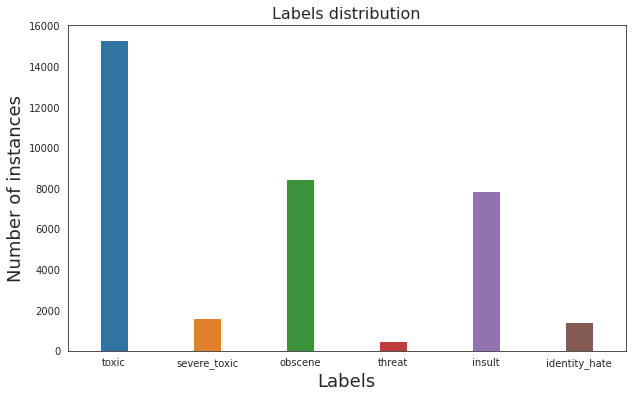

In [ ]:
plotHist(y=sum_labels, x=sum_labels.index, title='Labels distribution')

As we can see the labels distribution is also really unbalanced.

Let's also see how many labels are indipendent from one another.

In [ ]:
# filter instances for each category
# toxic
toxic = train[(train['toxic'] == 1) & (train['severe_toxic'] == 0) & (train['obscene'] == 0) & (train['threat'] == 0) & (train['insult'] == 0) & (train['identity_hate'] == 0)]
# severe toxic
severe_toxic = train[(train['toxic'] == 0) & (train['severe_toxic'] == 1) & (train['obscene'] == 0) & (train['threat'] == 0) & (train['insult'] == 0) & (train['identity_hate'] == 0)]
# obscene
obscene = train[(train['toxic'] == 0) & (train['severe_toxic'] == 0) & (train['obscene'] == 1) & (train['threat'] == 0) & (train['insult'] == 0) & (train['identity_hate'] == 0)]
# threat
threat = train[(train['toxic'] == 0) & (train['severe_toxic'] == 0) & (train['obscene'] == 0) & (train['threat'] == 1) & (train['insult'] == 0) & (train['identity_hate'] == 0)]
# insult
insult = train[(train['toxic'] == 0) & (train['severe_toxic'] == 0) & (train['obscene'] == 0) & (train['threat'] == 0) & (train['insult'] == 1) & (train['identity_hate'] == 0)]
# identity_hate
identity_hate = train[(train['toxic'] == 0) & (train['severe_toxic'] == 0) & (train['obscene'] == 0) & (train['threat'] == 0) & (train['insult'] == 0) & (train['identity_hate'] == 1)]

In [ ]:
print('Toxic:', len(toxic))
print('Severe Toxic:', len(severe_toxic))
print('Obscene:', len(obscene))
print('Threat:', len(threat))
print('Insult:', len(insult))
print('Identity Hate:', len(identity_hate))

Toxic: 5666
Severe Toxic: 0
Obscene: 317
Threat: 22
Insult: 301
Identity Hate: 54
